In [7]:
import pandas as pd
import numpy as np
import torch
import evaluate

from tqdm.auto import tqdm
from torch import nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import cross_entropy
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from accelerate import Accelerator, notebook_launcher
from accelerate.utils import set_seed
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, \
    TrainingArguments, Trainer, get_scheduler, PretrainedConfig, PreTrainedModel

np.random.seed(0) 
torch.manual_seed(0)

# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
test = pd.read_csv("data/goodreads_test.csv")
test.head()

,user_id,book_id,review_id,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,b9450d1c1f97f891c392b1105959b56e,7092507,5c4df7e70e9b438c761f07a4620ccb7c,** spoiler alert ** \n This is definitely one ...,Sat Nov 10 06:06:13 -0800 2012,Sun Nov 11 05:38:36 -0800 2012,Sun Nov 11 05:38:36 -0800 2012,Sat Nov 10 00:00:00 -0800 2012,1,0
1,b9450d1c1f97f891c392b1105959b56e,5576654,8eaeaf13213eeb16ad879a2a2591bbe5,"** spoiler alert ** \n ""You are what you drink...",Fri Nov 09 21:55:16 -0800 2012,Sat Nov 10 05:41:49 -0800 2012,Sat Nov 10 05:41:49 -0800 2012,Fri Nov 09 00:00:00 -0800 2012,1,0
2,b9450d1c1f97f891c392b1105959b56e,15754052,dce649b733c153ba5363a0413cac988f,Roar is one of my favorite characters in Under...,Fri Nov 09 00:25:50 -0800 2012,Sat Nov 10 06:14:10 -0800 2012,Sat Nov 10 06:14:10 -0800 2012,Fri Nov 09 00:00:00 -0800 2012,0,0
3,b9450d1c1f97f891c392b1105959b56e,17020,8a46df0bb997269d6834f9437a4b0a77,** spoiler alert ** \n If you feel like travel...,Thu Nov 01 00:28:39 -0700 2012,Sat Nov 03 11:35:22 -0700 2012,Sat Nov 03 11:35:22 -0700 2012,Thu Nov 01 00:00:00 -0700 2012,0,0
4,b9450d1c1f97f891c392b1105959b56e,12551082,d11d3091e22f1cf3cb865598de197599,3.5 stars \n I read and enjoyed the first two ...,Thu Oct 18 00:57:00 -0700 2012,Mon Apr 01 23:00:51 -0700 2013,Sat Mar 30 00:00:00 -0700 2013,Fri Mar 29 00:00:00 -0700 2013,0,0


In [3]:
test_df = test.loc[:, ["review_text"]]
test_df["rating"] = 0
test_df.head()

,review_text,rating
0,** spoiler alert ** \n This is definitely one ...,0
1,"** spoiler alert ** \n ""You are what you drink...",0
2,Roar is one of my favorite characters in Under...,0
3,** spoiler alert ** \n If you feel like travel...,0
4,3.5 stars \n I read and enjoyed the first two ...,0


In [4]:
test_ds = Dataset.from_pandas(test_df)

dataset = DatasetDict()
dataset["test"] = test_ds

dataset = dataset.rename_columns({"rating": "label"})
dataset

DatasetDict({
    test: Dataset({
        features: ['review_text', 'label'],
        num_rows: 478033
    })
})

In [5]:
tokenizer = AutoTokenizer.from_pretrained("models/tokenizer/")
tokenizer

PreTrainedTokenizerFast(name_or_path='models/tokenizer/', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

In [14]:
class CombinedConfig(PretrainedConfig):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

In [15]:
class CombinedModel(PreTrainedModel):
    def __init__(self, config, n_users, n_books, transformer_model_name,
                 n_factors=50, n_classes=6):
        super().__init__(config)
        self.user_embs = nn.Embedding(n_users, n_factors)
        self.book_embs = nn.Embedding(n_books, n_factors)
        self.text_transformer = AutoModelForSequenceClassification.from_pretrained(
            transformer_model_name, num_labels=512)
        self.linear_layers = nn.Sequential(
            nn.Linear(n_factors*2+512, 256, bias=True),
            nn.LeakyReLU(),
            nn.Linear(256, n_classes)
        )
        
    def forward(self, user_id=None, book_id=None,
                input_ids=None, attention_mask=None, labels=None):
        # first col: users, second col: books
        x_users = self.user_embs(user_id)
        x_books = self.book_embs(book_id)
        x_transformer = self.text_transformer(input_ids=input_ids,
                                              attention_mask=attention_mask).logits
        x = torch.cat([x_users, x_books, x_transformer], dim=-1)
        logits =  self.linear_layers(x)
        
        if labels is not None:
            loss = cross_entropy(logits, labels)
            return {"loss": loss, "logits": logits}
        
        return {"logits": logits}

In [16]:
config = CombinedConfig()
model = CombinedModel(config, 12189, 25475, "distilbert-base-uncased")

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [18]:
model.l

AttributeError: 'CombinedModel' object has no attribute 'model'

In [17]:
model.from_pretrained("models/combined_v2")

AttributeError: 'NoneType' object has no attribute 'from_pretrained'

In [14]:
pipe = pipeline("text-classification", model=model,
                tokenizer=tokenizer, device=0)
pipe

In [15]:
pipe("This book is awesome")

[{'label': 'LABEL_5', 'score': 0.7652255892753601}]

In [30]:
preds = []
for out in tqdm(pipe(KeyDataset(dataset["test"], "review_text"),
                     batch_size=32, padding="max_length", truncation=True)):
    preds.append(out["label"].split("_")[1])
len(preds)

  0%|          | 0/14939 [00:00<?, ?it/s]

478033

In [31]:
sub = pd.read_csv("data/goodreads_sample_submission.csv")
sub.shape

(478033, 2)

<AxesSubplot: ylabel='Frequency'>

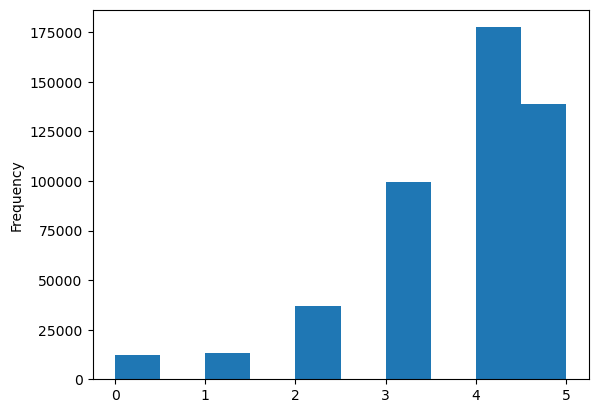

In [32]:
sub["rating"] = preds
sub["rating"] = sub["rating"].astype(int)
sub["rating"].plot.hist()

In [34]:
sub.to_csv("result/transformer_v2_preds.csv", index=False)